In [1]:
import torch
import emoji
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../')

from tqdm import tqdm
from config import GPT2EmojiConfig
from model import GPT2LMEmojiModel
from transformers import GPT2Tokenizer
from run_language_modeling import load_and_cache_examples, targets_mask
from sst_binary import sst_binary
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


MODEL_CLASSES = {
    "gpt2": (GPT2EmojiConfig, GPT2LMEmojiModel, GPT2Tokenizer),
}

MODEL_PATH = '../checkpoint-180000'

args = torch.load(os.path.join(MODEL_PATH, 'training_args.bin'))

config_class, model_class, tokenizer_class = MODEL_CLASSES['gpt2']

config = config_class.from_pretrained(MODEL_PATH)

tokenizer = tokenizer_class.from_pretrained(MODEL_PATH)

model = model_class.from_pretrained(
            MODEL_PATH,
            config=config,
)

map_target_to_token_id = dict(
        zip(range(0, len(emoji.UNICODE_EMOJI.keys())), tokenizer.encode(list(emoji.UNICODE_EMOJI.keys())))
)


Bad key "text.kerning_factor" on line 4 in
/home/jkarabl/anaconda3/envs/emoji-gpt2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


In [2]:
DATASETS = [
    'Olympic',
    'PsychExp',
    'SCv1',
    'SCv2-GEN',
    'SE0714',
    'SS-Twitter',
    'SS-Youtube',
]
DIR = '../data'
FILENAME_RAW = 'raw.pickle'
CLASSES = 'negative, positive'.split(', ')
TRAIN_SIZE = 1000

In [3]:
def load_dataset(dataset):
    print(dataset)
    DATASET_PATH = f'{DIR}/{dataset}/{FILENAME_RAW}'
    with open(DATASET_PATH, 'rb') as file:
        data = pickle.load(file, fix_imports=True, encoding='bytes')
    
    # Decode data
    texts = [str(x) for x in data[b'texts']]
    # Extract labels
    labels = [x[b'label'] for x in data[b'info']]
    return texts, labels

def decode(y_in):
    y_out = []
    for y in y_in:
        y_out.append(np.argmax(y))
    return y_out

In [4]:
X, y = load_dataset(DATASETS[5])

SS-Twitter


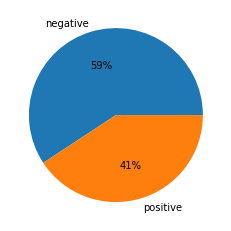

In [5]:
df = pd.DataFrame({'X': X, 'y': y})
ax = df.y.value_counts().plot.pie(labels=CLASSES, autopct='%1.0f%%')
ax.set_ylabel(None)
plt.savefig('SS-Twitter-classes.pdf', dpi=300)

In [6]:
pd.set_option('display.max_colwidth', 1000)

In [7]:
df.loc[df.y == 0]

,X,y
3,if my mom went on for the love of ray J or any reality show i'd bee pissed .,0
8,"@BarCough it's enough to make you sick, eh? there's nothing sacred anymore",0
9,"""Iran, with its unity and God's grace, will punch the arrogance (West) 22nd of Bahman (Feb 11) in a way that will leave them stunned,""",0
10,#4WordsOnObamasHand Don't Say The N-Word,0
11,City watchdog in chaos as chief executive Hector Sants resigns just months before general election,0
...,...,...
2102,"bored, well you can always visit the blog-murmurings of @teraknor at http://bit.ly/dh6i8I",0
2103,im reeeeallly bored. anyone gonna talk?,0
2104,"Never by tea at Schiphol airport, it's expensive and you get a lousy cup of tea!",0
2110,I see some TT I wanna go in on but I don't got no time to chat. I gotta go be a somebody's slave right now.,0


In [8]:
df.loc[df.y == 1]

,X,y
0,"Listening to the ""New Age"" station on @SlackerRadio ? http://slacker.com/r/nqKf",1
1,i didnt mean knee high I ment in lengt it goes down to my knees - and is so cute I love it!,1
2,I wana see the vid Kyan,1
4,@Mrhilton1985 Welcome to Twitter xx,1
5,"@kjbmusic oh yeah... however, I'd still like to be in the midst of it all though... u know...",1
...,...,...
2106,"@tittoantony minnor one's first day in my pre, but i ragged many, In my pre & in my degree :D",1
2107,"@missjuicybq yeap....*sings* WIPE OUTTTTTTT, don nun nun nun nun nunna nunt. Lol, we sure would.",1
2108,30 SEconds To Mars tomarrow :) niiice,1
2109,"RT @DIME10_DIVA: @MZMOODY I like my babe's tat there....""great minds think alike"" --YEA ITS NICE MAKE ME WANNA GET ANOTHER",1


In [7]:
Xt = tokenize(X, tokenizer)

In [8]:
trXt, teXt, trY, teY = train_test_split(Xt, y, train_size=TRAIN_SIZE, random_state=42)

In [9]:
mean_preds = predict_mean(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [01:17<00:00, 12.89it/s]


In [10]:
last_preds = predict_last(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]


In [11]:
max_preds = predict_max(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 1000/1000 [01:27<00:00, 11.45it/s]


In [12]:
mean_cm = pd.crosstab(pd.Series(mean_preds), pd.Series(trY))
mean_cm

col_0,0,1
row_0,,
✅,0,1
✨,1,9
❤,0,9
➡,53,76
🍕,0,1
🎂,0,2
🎉,0,1
🎶,2,0
👀,0,9


In [13]:
last_cm = pd.crosstab(pd.Series(last_preds), pd.Series(trY))
last_cm

col_0,0,1
row_0,,
✅,0,2
✨,3,13
❤,4,10
➡,38,51
🇺,0,1
...,...,...
🙃,7,0
🙄,4,5
🙏,1,13


In [14]:
max_cm = pd.crosstab(pd.Series(max_preds), pd.Series(trY))
max_cm

col_0,0,1
row_0,,
✅,3,3
✨,0,6
❤,0,3
➡,55,90
🇺,1,0
...,...,...
🙏,1,9
🚀,0,1
🛌,1,0


In [15]:
cramers_corrected_stat(mean_cm.to_numpy())

0.32665083612835466

In [16]:
cramers_corrected_stat(last_cm.to_numpy())

0.40285674027427265

In [17]:
cramers_corrected_stat(max_cm.to_numpy())

0.31841320051535843

In [18]:
theil_u(trY, mean_preds)

0.12872417904790137

In [19]:
theil_u(trY, last_preds)

0.20163576092682717

In [20]:
theil_u(trY, max_preds)

0.15497369966398533

## Logreg

In [21]:
Xtrans_last = transform_last(X, model, tokenizer, args)

100%|██████████| 2113/2113 [03:50<00:00,  9.16it/s]


In [22]:
Xtrans_mean = transform_mean(X, model, tokenizer, args)

100%|██████████| 2113/2113 [04:40<00:00,  7.54it/s]


In [23]:
Xtrans_max = transform_max(X, model, tokenizer, args)

100%|██████████| 2113/2113 [06:06<00:00,  5.77it/s]


In [24]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_last, y, train_size=TRAIN_SIZE, random_state=42)

In [26]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.00390625, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.00390625,
 [0.8337825696316262,
  0.8301886792452831,
  0.8328840970350404,
  0.8283917340521114,
  0.8176100628930818,
  0.8131176999101527,
  0.8068283917340521,
  0.7960467205750225,
  0.7852650494159928])

In [27]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_mean, y, train_size=TRAIN_SIZE, random_state=42)

In [28]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.0625, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.0625,
 [0.8203054806828391,
  0.8221024258760108,
  0.8247978436657682,
  0.8247978436657682,
  0.8310871518418689,
  0.825696316262354,
  0.8230008984725966,
  0.8185085354896675,
  0.8149146451033243])

In [29]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_max, y, train_size=TRAIN_SIZE, random_state=42)

In [30]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.00390625, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.00390625,
 [0.8005390835579514,
  0.8005390835579514,
  0.7978436657681941,
  0.793351302785265,
  0.7915543575920935,
  0.784366576819407,
  0.7879604672057502,
  0.7780772686433064,
  0.7744833782569631])

## Vanilla GPT-2

In [5]:
from transformers import GPT2Model

model_version = 'gpt2'
model_gpt2 = GPT2Model.from_pretrained(model_version)
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained(model_version)

In [6]:
Xtrans_gpt2 = transform_gpt2(X, model_gpt2, tokenizer_gpt2)

100%|██████████| 2113/2113 [02:32<00:00, 13.85it/s]


In [7]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_gpt2, y, train_size=TRAIN_SIZE, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.0625, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.0625,
 [0.713666452134623,
  0.7304837377229753,
  0.7567255316934394,
  0.7741741349308426,
  0.7743673833883769,
  0.7743170572117941,
  0.76244698006586,
  0.7536162576127292,
  0.7448125644846957])

In [8]:
Xtrans_emoji = transform_emoji(X, model, tokenizer)

100%|██████████| 2113/2113 [02:46<00:00, 12.72it/s]


In [9]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_emoji, y, train_size=TRAIN_SIZE, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.00390625, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.00390625,
 [0.8236259354680406,
  0.8215737772017191,
  0.818805812656139,
  0.8182498588156847,
  0.8163566281783481,
  0.8069874167283494,
  0.7944570606028154,
  0.7841728611662588,
  0.7790923770436655])